<a name="top" id="top"></a>

<div align="center">
    <h1>Integrated Optimization of Pharmaceutical Manufacturing Networks: A Mixed-Integer Programming Framework for Strategic Vendor and Transportation Management</h1>
    <a href="https://github.com/sa1K">Sai Karthik</a>
    <br>
    <i>Weldon School of Biomedical Engineering, Purdue University</i>
    <br>
    <br>
    <a href="https://github.com/parkyr">Yirang Park</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <br>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <br>
    <a href="" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

# Imports and setup

## Pyomo import

In [4]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Let's start with Pyomo
if IN_COLAB:
    !pip install -q pyomo

## Installing graph visualization tools

In [5]:
if IN_COLAB:
  !sudo apt-get install graphviz graphviz-dev
  !pip install networkx

## Imports

In [6]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import time
import matplotlib.pyplot as plt
import graphviz

## Instance generator

In [7]:
"""Random instance generator for pharmaceutical optimization flowsheet.

This module generates random test data for pharmaceutical manufacturing optimization
problems, creating CSV files with manufacturing and transportation data.
"""

import random
import pandas as pd
from openpyxl.utils import get_column_letter


class Generator:
    """Generates random manufacturing and transportation data for optimization models.

    This class creates synthetic data for multi-step pharmaceutical manufacturing
    processes with multiple vendor options at each step."""
    def __init__(self, steps: int, options: int):
        """Initialize the generator with problem dimensions.

        Args:
            steps: Number of manufacturing steps in the process.
            options: Number of vendor options available at each step.
        """
        self.steps = steps
        self.options = options

    def number_to_letters(self, n):
        """Convert a number to Excel-style column letters (1=A, 26=Z, 27=AA, etc.).

        Args:
            n: Positive integer to convert.

        Returns:
            String representation using letters (e.g., 1 -> 'A', 27 -> 'AA').
        """
        return get_column_letter(n)

    def saveDataToCSV(self, df: pd.DataFrame, filename: str):
        """Save a DataFrame to a CSV file.

        Args:
            df: The pandas DataFrame to save.
            filename: The name of the output CSV file (with or without .csv extension).
        """
        if not filename.endswith('.csv'):
            filename += '.csv'
        df.to_csv(filename, index=False)

    def generateManufacturingData(self) -> pd.DataFrame:
        """Generate random manufacturing data and return as DataFrame.

        Returns:
            DataFrame with columns:
            - step: Manufacturing step number (1 to steps)
            - Vendor: Vendor identifier (letter-based: A, B, C, ...)
            - Production: Random production capacity (1 to 99,999)
            - Cost: Random manufacturing cost (1 to 99,999)

            Contains one row for each (step, vendor) combination.
        """
        data = []
        for step in range(1, self.steps + 1):
            for option in range(1, self.options + 1):
                data.append({
                    'step': step,
                    'Vendor': self.number_to_letters(option),
                    'Production': random.randrange(1, 100000),
                    'Cost': random.randrange(1, 100000)
                })
        return pd.DataFrame(data)

    def generateTransportData(self) -> pd.DataFrame:
        """Generate random transportation data and return as DataFrame.

        Returns:
            DataFrame with columns:
            - SourceStep: Source manufacturing step number
            - DestinationStep: Destination manufacturing step number (SourceStep + 1)
            - SourceVendor: Source vendor identifier (letter-based)
            - DestinationVendor: Destination vendor identifier (letter-based)
            - TransportationCost: Transportation cost (0 if same vendor, otherwise 1 to 100)

            Contains one row for each possible transition between consecutive steps and
            vendor pairs. Transportation cost is 0 when the same vendor handles both steps.
        """
        data = []
        for step in range(1, self.steps):
            for option1 in range(1, self.options + 1):
                for option2 in range(1, self.options + 1):
                    vendor1 = self.number_to_letters(option1)
                    vendor2 = self.number_to_letters(option2)
                    cost = 0 if vendor1 == vendor2 else random.randrange(1, 101)
                    data.append({
                        'SourceStep': step,
                        'DestinationStep': step + 1,
                        'SourceVendor': vendor1,
                        'DestinationVendor': vendor2,
                        'TransportationCost': cost
                    })
        return pd.DataFrame(data)

    def createManufacturingData(self, filename: str = "manufacturingData2.csv"):
        """Generate random manufacturing data and save to CSV file.

        Args:
            filename: Name of the output CSV file (default: "manufacturingData2.csv")

        Creates a CSV file with columns:
        - step: Manufacturing step number (1 to steps)
        - Vendor: Vendor identifier (letter-based: A, B, C, ...)
        - Production: Random production capacity (1 to 99,999)
        - Cost: Random manufacturing cost (1 to 99,999)

        The file contains one row for each (step, vendor) combination.
        """
        df = self.generateManufacturingData()
        self.saveDataToCSV(df, filename)

    def createTransportData(self, filename: str = "transportData2.csv"):
        """Generate random transportation data and save to CSV file.

        Args:
            filename: Name of the output CSV file (default: "transportData2.csv")

        Creates a CSV file with columns:
        - SourceStep: Source manufacturing step number
        - DestinationStep: Destination manufacturing step number (SourceStep + 1)
        - SourceVendor: Source vendor identifier (letter-based)
        - DestinationVendor: Destination vendor identifier (letter-based)
        - TransportationCost: Transportation cost (0 if same vendor, otherwise 1 to 100)

        The file contains one row for each possible transition between consecutive
        steps and vendor pairs. Transportation cost is 0 when the same vendor handles
        both steps (no physical transport needed).
        """
        df = self.generateTransportData()
        self.saveDataToCSV(df, filename)

Generating instance

In [8]:
generator = Generator(3, 3)
generator.createManufacturingData()
generator.createTransportData()

## Installing solvers

In [9]:
if IN_COLAB:
    !apt-get install -y -qq glpk-utils
    !pip install highspy
    !pip install -q condacolab
    import condacolab
    condacolab.install()
    !conda install pyscipopt

# Enhanced Pharmaceutical Manufacturing Optimization
## Integration of Production and Transport Costs

This notebook extends the original pharmaceutical site selection optimization to include transport costs between vendors across sequential manufacturing steps. The enhanced model provides a more realistic cost optimization by considering the full supply chain.

## Enhanced Production Optimizer Class

The `EnhancedProductionOptimizer` extends the original model to include:
- Transport costs between vendors in consecutive steps
- Flow consistency constraints
- Comprehensive cost breakdown (production + transport)

In [10]:
class EnhancedProductionOptimizer:
    """
    Enhanced production optimizer that incorporates both production costs and transport costs
    between vendors across sequential steps.

    Production CSV must have columns: [step, Vendor, Production, Cost]
    Transport CSV must have columns: [Step1, Step2, Vendor1, Vendor2, TransCost]
    """

    def __init__(self, prod_cost_csv: str, transport_cost_csv: str, demand: float):
        """
        Initialize by loading data and constructing the enhanced Pyomo model.

        :param prod_cost_csv: Path to CSV with columns [step, Vendor, Production, Cost]
        :param transport_cost_csv: Path to CSV with columns [Step1, Step2, Vendor1, Vendor2, TransCost]
        :param demand: Total demand that must be satisfied
        """
        # Load production data
        self.prod_df = pd.read_csv(prod_cost_csv)
        self.transport_df = pd.read_csv(transport_cost_csv)
        self.demand = demand

        # Process production data
        self.vendors = (
            self.prod_df
            .groupby("step")["Vendor"]
            .apply(list)
            .to_dict()
        )

        # (step, vendor) pairs
        self.pairs = list(self.prod_df[["step","Vendor"]]
                          .itertuples(index=False, name=None))

        # Production lookup dicts
        self.prod_dict = {
            (r.step, r.Vendor): r.Production
            for r in self.prod_df.itertuples()
        }
        self.cost_dict = {
            (r.step, r.Vendor): r.Cost
            for r in self.prod_df.itertuples()
        }

        # Process transport data
        self.transport_dict = {
            (r.SourceStep, r.SourceVendor, r.DestinationStep, r.DestinationVendor): r.TransportationCost
            for r in self.transport_df.itertuples()
        }

        # Get all transport routes (step1, vendor1, step2, vendor2)
        self.transport_routes = list(self.transport_dict.keys())

        # Get ordered steps
        self.ordered_steps = sorted(self.vendors.keys())

        # Build model
        self._build_model()

    def _build_model(self):
        """
        Initialize by loading data and constructing the enhanced Pyomo model.

        """
        m = pyo.ConcreteModel()

        # Sets
        m.steps = pyo.Set(initialize=self.vendors.keys())
        m.step_option = pyo.Set(dimen=2, initialize=self.pairs)
        m.transport_routes = pyo.Set(dimen=4, initialize=self.transport_routes)

        # Parameters
        m.production = pyo.Param(
            m.step_option, initialize=self.prod_dict,
            within=pyo.NonNegativeReals
        )
        m.prod_cost = pyo.Param(
            m.step_option, initialize=self.cost_dict,
            within=pyo.NonNegativeReals
        )
        m.transport_cost = pyo.Param(
            m.transport_routes, initialize=self.transport_dict,
            within=pyo.NonNegativeReals
        )
        m.demand = pyo.Param(initialize=self.demand,
                             within=pyo.NonNegativeReals)

        # Decision variables
        m.x = pyo.Var(m.step_option, domain=pyo.Binary)  # vendor selection
        m.y = pyo.Var(m.transport_routes, domain=pyo.Binary)  # transport route selection

        # Constraints

        # One vendor per step
        def one_per_step(mdl, step):
            return sum(mdl.x[step, v] for v in self.vendors[step]) == 1
        m.one_per_step = pyo.Constraint(m.steps, rule=one_per_step)

        # Production level constraint
        def prod_level(mdl):
            return sum(
                mdl.production[s, o] * mdl.x[s, o]
                for s, o in mdl.step_option
            ) >= mdl.demand
        m.prod_level = pyo.Constraint(rule=prod_level)

        # Only one transport route per consecutive step pair
        for i in range(len(self.ordered_steps) - 1):
            step1, step2 = self.ordered_steps[i], self.ordered_steps[i + 1]

            def transport_selection_rule(mdl):
                valid_routes = [
                    (s1, v1, s2, v2) for (s1, v1, s2, v2) in self.transport_routes
                    if s1 == step1 and s2 == step2
                ]
                if valid_routes:
                    return sum(mdl.y[route] for route in valid_routes) == 1
                else:
                    return pyo.Constraint.Skip

            setattr(m, f'transport_selection_{step1}_{step2}',
                   pyo.Constraint(rule=transport_selection_rule))

        # Link transport routes to vendor selection
        for step1, vendor1, step2, vendor2 in self.transport_routes:
            def link_transport_rule(mdl):
                return mdl.y[step1, vendor1, step2, vendor2] <= mdl.x[step1, vendor1]

            def link_transport_rule2(mdl):
                return mdl.y[step1, vendor1, step2, vendor2] <= mdl.x[step2, vendor2]

            setattr(m, f'link_transport_{step1}_{vendor1}_{step2}_{vendor2}_1',
                   pyo.Constraint(rule=link_transport_rule))
            setattr(m, f'link_transport_{step1}_{vendor1}_{step2}_{vendor2}_2',
                   pyo.Constraint(rule=link_transport_rule2))

        # Objective: minimize production costs + transport costs
        m.obj = pyo.Objective(
            expr=sum(m.prod_cost[s, o] * m.x[s, o] for s, o in m.step_option) +
                 sum(m.transport_cost[route] * m.y[route] for route in m.transport_routes),
            sense=pyo.minimize
        )

        self.model = m

    def get_selected_options(self):
        """
        Retrieve the chosen vendor for each step.

        :return: dict mapping step -> selected vendor
        """
        selections = {}
        for (s, v) in self.model.step_option:
            if pyo.value(self.model.x[s, v]) > 0.5:
                selections[s] = v
        return selections

    def get_selected_transport_routes(self):
        """
        Retrieve the selected transport routes.

        :return: list of selected transport routes
        """
        selected_routes = []
        for route in self.model.transport_routes:
            if pyo.value(self.model.y[route]) > 0.5:
                selected_routes.append(route)
        return selected_routes

    def get_total_production_cost(self):
        """
        Compute the total production cost of the solution.

        :return: float
        """
        return sum(
            pyo.value(self.model.prod_cost[s, o] * self.model.x[s, o])
            for s, o in self.model.step_option
        )

    def get_total_transport_cost(self):
        """
        Compute the total transport cost of the solution.

        :return: float
        """
        return sum(
            pyo.value(self.model.transport_cost[route] * self.model.y[route])
            for route in self.model.transport_routes
        )

    def get_total_cost(self):
        """
        Compute the total cost (production + transport) of the solution.

        :return: float
        """
        return pyo.value(self.model.obj)

    def summary(self):
        """
        Print a detailed summary of results including transport routes.
        """
        selections = self.get_selected_options()
        transport_routes = self.get_selected_transport_routes()

        print("=== OPTIMIZATION RESULTS ===")
        print("\nSelected vendors by step:")
        for step in sorted(selections.keys()):
            vendor = selections[step]
            prod_cost = self.cost_dict[(step, vendor)]
            production = self.prod_dict[(step, vendor)]
            print(f"  Step {step}: {vendor} (Cost: ${prod_cost}, Production: {production})")

        print("\nSelected transport routes:")
        for step1, vendor1, step2, vendor2 in sorted(transport_routes):
            trans_cost = self.transport_dict[(step1, vendor1, step2, vendor2)]
            print(f"  Step {step1}({vendor1}) → Step {step2}({vendor2}): ${trans_cost}")

        print(f"\n=== COST BREAKDOWN ===")
        print(f"Total production cost: ${self.get_total_production_cost():.2f}")
        print(f"Total transport cost: ${self.get_total_transport_cost():.2f}")
        print(f"TOTAL COST: ${self.get_total_cost():.2f}")

        # Show the complete path
        print(f"\n=== OPTIMAL PATH ===")
        path_str = " → ".join([f"Step {s}({selections[s]})" for s in sorted(selections.keys())])
        print(f"Path: {path_str}")

## Load and Examine Data

First, let's examine the production and transport cost data to understand the structure.

In [ ]:
# Load and display production data
prod_df = pd.read_csv("manufacturingData2.csv")
print("Production Data:")
print(prod_df)
print("\n" + "="*50)

# Load and display transport data
transport_df = pd.read_csv("transportData2.csv")
print("\nTransport Data:")
print(transport_df)

Production Data:
   step Vendor  Production   Cost
0     1      A       70930  14846
1     1      B        3449  71428
2     1      C       84489  51441
3     2      A        6665  77607
4     2      B       59390  92631
5     2      C       71882  92561
6     3      A       58445  55704
7     3      B       95239  76532
8     3      C       91906  68856


Transport Data:
    SourceStep  DestinationStep SourceVendor DestinationVendor  \
0            1                2            A                 A   
1            1                2            A                 B   
2            1                2            A                 C   
3            1                2            B                 A   
4            1                2            B                 B   
5            1                2            B                 C   
6            1                2            C                 A   
7            1                2            C                 B   
8            1                2

## Run Enhanced Optimization

Now let's solve the enhanced optimization problem that includes both production and transport costs.

In [12]:
# Create and solve the enhanced optimization model
enhanced_optimizer = EnhancedProductionOptimizer(
    "manufacturingData2.csv",
    "transportData2.csv",
    demand=100
)


# Solve using your preferred solver
if IN_COLAB:
    opt = pyo.SolverFactory('glpk', executable='/usr/bin/glpsol')
else:
    opt = pyo.SolverFactory('glpk')
result = opt.solve(enhanced_optimizer.model, tee=False)

print(f"Solver status: {result.solver.termination_condition}")
enhanced_optimizer.summary()

Solver status: optimal
=== OPTIMIZATION RESULTS ===

Selected vendors by step:
  Step 1: A (Cost: $14846, Production: 70930)
  Step 2: A (Cost: $77607, Production: 6665)
  Step 3: A (Cost: $55704, Production: 58445)

Selected transport routes:
  Step 1(A) → Step 2(A): $0
  Step 2(A) → Step 3(A): $0

=== COST BREAKDOWN ===
Total production cost: $148157.00
Total transport cost: $0.00
TOTAL COST: $148157.00

=== OPTIMAL PATH ===
Path: Step 1(A) → Step 2(A) → Step 3(A)


## Visualization Functions

Functions to visualize the optimization solution directly from the optimizer object.

In [13]:
def visualize_solution_from_optimizer(optimizer, title="Optimization Solution Path"):
    """Create a visual representation of the pharmaceutical optimization solution.

    Generates a directed graph showing the manufacturing process flow,
    highlighting the selected vendors/options at each step.

    Args:
        optimizer (EnhancedProductionOptimizer): The optimizer object with solved model
        title (str): Title for the visualization plot

    Returns:
        tuple: Contains (G, pos, chosen) where:
            - G (nx.DiGraph): NetworkX directed graph object
            - pos (dict): Node positions for visualization
            - chosen (list): List of (step, option) tuples representing the solution path
    """

    # Get solution data from optimizer
    vendors = optimizer.vendors
    selections = optimizer.get_selected_options()

    # Sort manufacturing steps in ascending order
    steps = sorted(vendors.keys())

    # Create directed graph for the manufacturing process
    G = nx.DiGraph()
    START = 'Start'
    G.add_node(START)

    # Add nodes for each vendor option at each manufacturing step
    for step in steps:
        for opt in vendors[step]:
            G.add_node((step, opt))

    # Extract the selected solution path
    chosen = [(step, vendor) for step, vendor in sorted(selections.items())]

    # Build the actual solution path edges
    real_edges = []

    if chosen:
        real_edges.append((START, chosen[0]))

    for a, b in zip(chosen, chosen[1:]):
        real_edges.append((a, b))

    # Calculate node positions using hierarchical layout
    # Assign each node to a layer based on its manufacturing step
    pos = {}

    # Position START node
    pos[START] = (0, 0)

    # Position nodes in vertical columns by manufacturing step
    horizontal_spacing = 3.0
    vertical_spacing = 2.0

    for step_idx, step in enumerate(steps):
        x = (step_idx + 1) * horizontal_spacing  # Horizontal position (column)
        num_options = len(vendors[step])

        # Center the options vertically
        for option_idx, option in enumerate(vendors[step]):
            y = (option_idx - (num_options - 1) / 2) * vertical_spacing
            pos[(step, option)] = (x, y)

    # Initialize matplotlib figure
    plt.figure(figsize=(12, 8))

    # Draw all possible edges (faint background connections)
    all_edges = []
    all_edges.extend([(START, (steps[0], opt)) for opt in vendors[steps[0]]])
    for i in range(len(steps) - 1):
        current_step = steps[i]
        next_step = steps[i + 1]
        for opt1 in vendors[current_step]:
            for opt2 in vendors[next_step]:
                all_edges.append(((current_step, opt1), (next_step, opt2)))

    nx.draw_networkx_edges(
        G, pos,
        edgelist=all_edges,
        edge_color='lightgray',
        width=0.5,
        alpha=0.3,
        arrows=False
    )

    # Draw the selected solution path (highlighted)
    if real_edges:
        nx.draw_networkx_edges(
            G, pos,
            edgelist=real_edges,
            arrowstyle='-|>',
            arrowsize=16,
            edge_color='red',
            width=3,
            alpha=0.8
        )

    # Color palette for different manufacturing steps
    colors = ['skyblue', 'lightgreen', 'orange', 'violet', 'gold', 'pink', 'lightcoral']

    # Draw nodes for each manufacturing step
    for idx, step in enumerate(steps):
        step_nodes = [(step, o) for o in vendors[step]]
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=step_nodes,
            node_color=colors[idx % len(colors)],
            node_shape='s',
            node_size=1200,
            alpha=0.8
        )

    # Draw the start node
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[START],
        node_color='darkgreen',
        node_shape='s',
        node_size=1500,
        alpha=0.9
    )

    # Create node labels
    labels = {START: 'Start'}
    labels.update({(step, o): f"Step {step}\n{o}" for step in steps for o in vendors[step]})

    # Draw labels
    nx.draw_networkx_labels(G, pos, labels,
                           font_color='white',
                           font_weight='bold',
                           font_size=9)

    # Configure plot appearance
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()

    return G, pos, chosen

## Visualize the Solution

Create the network diagram showing the optimal path.

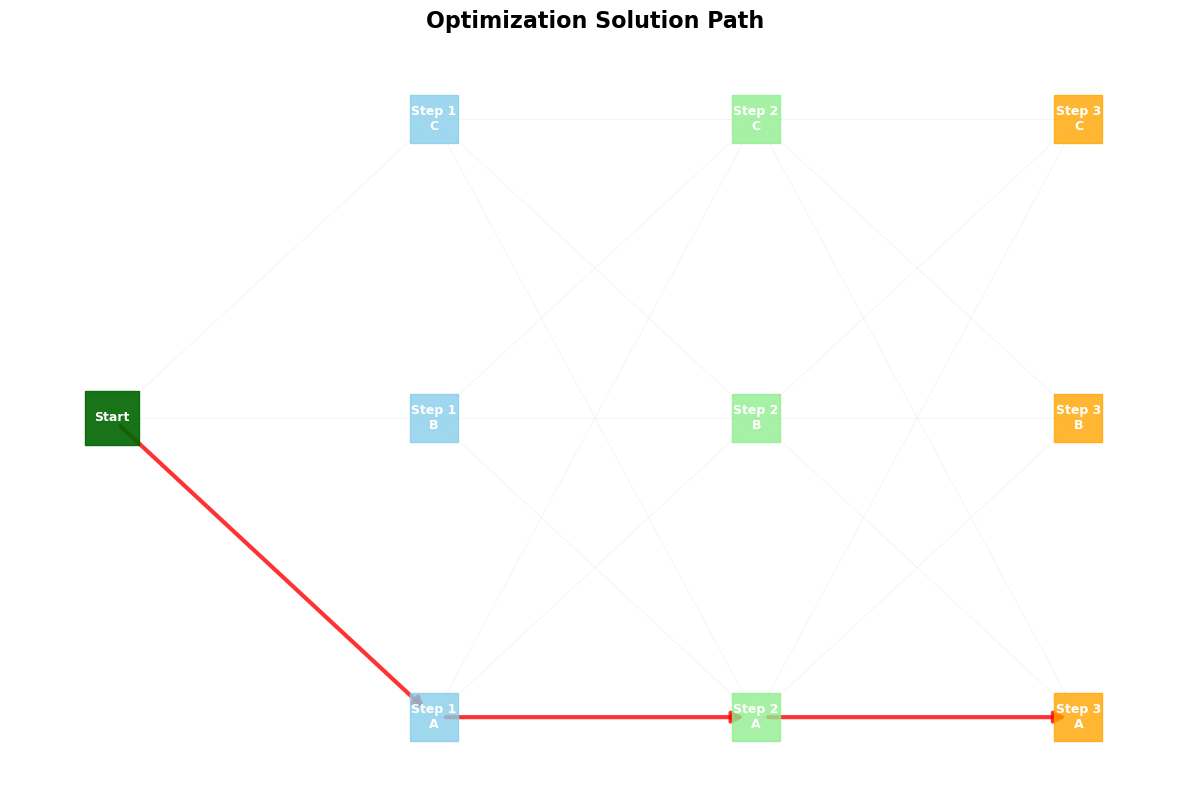


Visualization complete!
Found 3 steps with 9 total vendor options
Selected path has 3 steps


In [14]:
# Generate and display the visualization
G, pos, chosen_path = visualize_solution_from_optimizer(enhanced_optimizer)

plt.show()

print(f"\nVisualization complete!")
print(f"Found {len(enhanced_optimizer.vendors)} steps with {sum(len(v) for v in enhanced_optimizer.vendors.values())} total vendor options")
print(f"Selected path has {len(chosen_path)} steps")

# How does the solution scale?

Size 5: glpk=0.015s, HiGHS=0.015s, SCIP=0.020s
Size 10: glpk=0.039s, HiGHS=0.094s, SCIP=0.080s
Size 15: glpk=0.583s, HiGHS=0.751s, SCIP=0.360s
Size 20: glpk=2.194s, HiGHS=0.595s, SCIP=0.710s
Size 25: glpk=7.486s, HiGHS=1.058s, SCIP=2.000s
Size 30: glpk=58.198s, HiGHS=2.094s, SCIP=3.840s


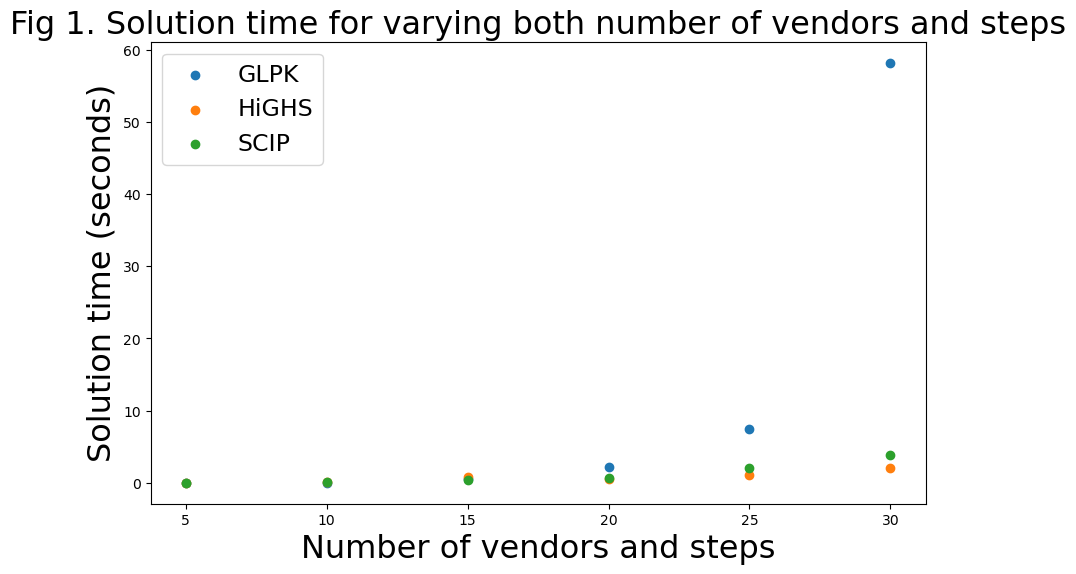

In [19]:
time_to_run_glpk = []
time_to_run_highs = []
time_to_run_scip = []

for i in range(5,35,5):
    #start_time = time.time()  # Start timing

    generator = Generator(i, i)
    generator.createManufacturingData()
    generator.createTransportData()


    enhanced_optimizer = EnhancedProductionOptimizer(
        "manufacturingData2.csv",
        "transportData2.csv",
        demand=100
    )

    # Solve using your preferred solver
    opt = pyo.SolverFactory('glpk')
    result = opt.solve(enhanced_optimizer.model, tee=False)
    time_to_run_glpk.append(result.solver.time)

    opt = pyo.SolverFactory('highs')
    t0 = time.perf_counter()
    result = opt.solve(enhanced_optimizer.model, tee=False)
    time_to_run_highs.append(time.perf_counter() - t0)

    opt = pyo.SolverFactory('scip')
    result = opt.solve(enhanced_optimizer.model, tee=False)
    time_to_run_scip.append(result.solver.time)

    print(f"Size {i}: glpk={time_to_run_glpk[-1]:.3f}s, HiGHS={time_to_run_highs[-1]:.3f}s, SCIP={time_to_run_scip[-1]:.3f}s")
    #plt.close()

fig,ax = plt.subplots(figsize=(10, 6))
ax.scatter(range(5,35,5),time_to_run_glpk, label = "GLPK")
ax.scatter(range(5,35,5), time_to_run_highs, label = "HiGHS")
ax.scatter(range(5,35,5), time_to_run_scip, label = "SCIP")
ax.set_xlabel("Number of vendors and steps", fontsize=23)
ax.set_ylabel("Solution time (seconds)", fontsize=23)
ax.set_title("Fig 1. Solution time for varying both number of vendors and steps", fontsize=23)
ax.legend(fontsize = 17)

Size 5: GLPK=0.012s, HiGHS=0.013s, SCIP=0.010s
Size 10: GLPK=0.012s, HiGHS=0.021s, SCIP=0.010s
Size 15: GLPK=0.015s, HiGHS=0.029s, SCIP=0.020s
Size 20: GLPK=0.016s, HiGHS=0.036s, SCIP=0.040s
Size 25: GLPK=0.019s, HiGHS=0.048s, SCIP=0.050s
Size 30: GLPK=0.024s, HiGHS=0.050s, SCIP=0.080s


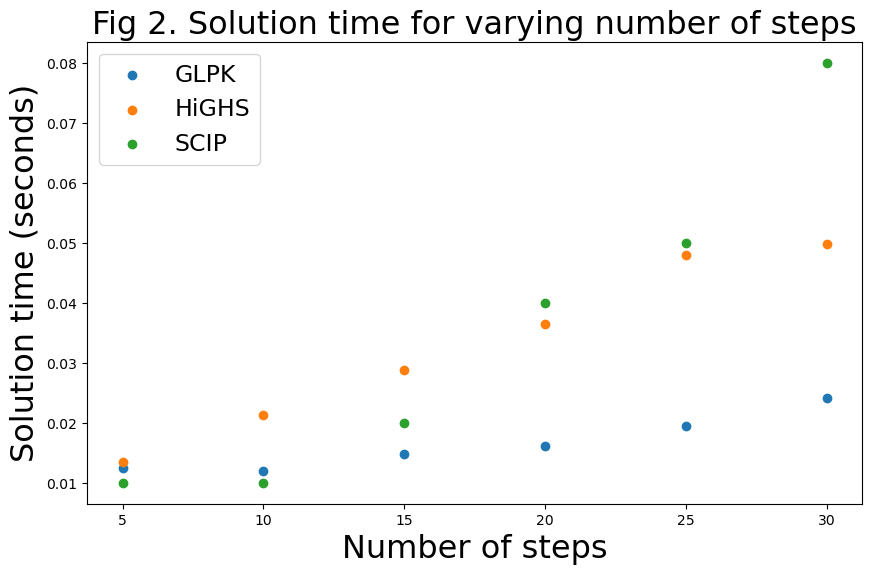

In [20]:
time_to_run_glpk = []
time_to_run_highs = []
time_to_run_scip = []

for i in range(5,35,5):
    #start_time = time.time()  # Start timing

    generator = Generator(i, 5)
    generator.createManufacturingData()
    generator.createTransportData()


    enhanced_optimizer = EnhancedProductionOptimizer(
        "manufacturingData2.csv",
        "transportData2.csv",
        demand=100
    )

    # Solve using your preferred solver
    opt = pyo.SolverFactory('glpk')
    result = opt.solve(enhanced_optimizer.model, tee=False)
    time_to_run_glpk.append(result.solver.time)

    opt = pyo.SolverFactory('highs')
    t0 = time.perf_counter()
    result = opt.solve(enhanced_optimizer.model, tee=False)
    time_to_run_highs.append(time.perf_counter() - t0)

    opt = pyo.SolverFactory('scip')
    result = opt.solve(enhanced_optimizer.model, tee=False)
    time_to_run_scip.append(result.solver.time)

    print(f"Size {i}: GLPK={time_to_run_glpk[-1]:.3f}s, HiGHS={time_to_run_highs[-1]:.3f}s, SCIP={time_to_run_scip[-1]:.3f}s")
    #plt.close()

fig,ax = plt.subplots(figsize=(10, 6))
ax.scatter(range(5,35,5),time_to_run_glpk, label = "GLPK")
ax.scatter(range(5,35,5), time_to_run_highs, label = "HiGHS")
ax.scatter(range(5,35,5), time_to_run_scip, label = "SCIP")
ax.set_xlabel("Number of steps", fontsize=23)
ax.set_ylabel("Solution time (seconds)", fontsize=23)
ax.set_title("Fig 2. Solution time for varying number of steps", fontsize=23)
ax.legend(fontsize = 17)

Size 5: glpk=0.014s, HiGHS=0.015s, SCIP=0.000s
Size 10: glpk=0.024s, HiGHS=0.081s, SCIP=0.000s
Size 15: glpk=0.048s, HiGHS=0.137s, SCIP=0.000s
Size 20: glpk=0.089s, HiGHS=0.176s, SCIP=0.010s
Size 25: glpk=0.366s, HiGHS=0.290s, SCIP=0.010s
Size 30: glpk=0.461s, HiGHS=0.530s, SCIP=0.020s


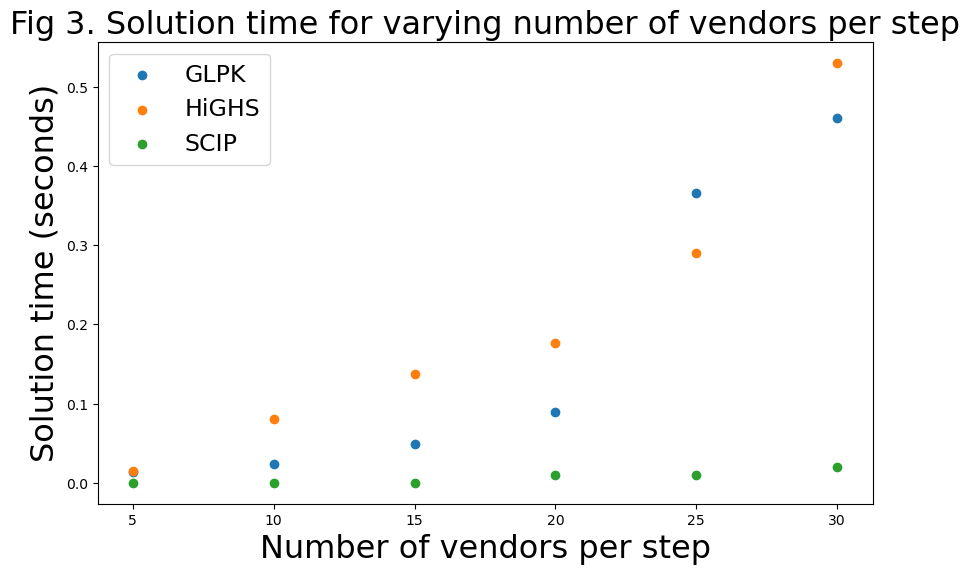

In [21]:
time_to_run_glpk = []
time_to_run_highs = []
time_to_run_scip = []

for i in range(5,35,5):
    #start_time = time.time()  # Start timing

    generator = Generator(5, i)
    generator.createManufacturingData()
    generator.createTransportData()


    enhanced_optimizer = EnhancedProductionOptimizer(
        "manufacturingData2.csv",
        "transportData2.csv",
        demand=100
    )

    # Solve using your preferred solver
    opt = pyo.SolverFactory('glpk')
    result = opt.solve(enhanced_optimizer.model, tee=False)
    time_to_run_glpk.append(result.solver.time)

    opt = pyo.SolverFactory('highs')
    t0 = time.perf_counter()
    result = opt.solve(enhanced_optimizer.model, tee=False)
    time_to_run_highs.append(time.perf_counter() - t0)

    opt = pyo.SolverFactory('scip')
    result = opt.solve(enhanced_optimizer.model, tee=False)
    time_to_run_scip.append(result.solver.time)

    print(f"Size {i}: glpk={time_to_run_glpk[-1]:.3f}s, HiGHS={time_to_run_highs[-1]:.3f}s, SCIP={time_to_run_scip[-1]:.3f}s")
    #plt.close()

fig,ax = plt.subplots(figsize=(10, 6))
ax.scatter(range(5,35,5),time_to_run_glpk, label = "GLPK")
ax.scatter(range(5,35,5), time_to_run_highs, label = "HiGHS")
ax.scatter(range(5,35,5), time_to_run_scip, label = "SCIP")
ax.set_xlabel("Number of vendors per step", fontsize=23)
ax.set_ylabel("Solution time (seconds)", fontsize=23)
ax.set_title("Fig 3. Solution time for varying number of vendors per step", fontsize = 23)
ax.legend(fontsize = 17)